In [254]:
from fbprophet import Prophet
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date, datetime
current_date = datetime.today().strftime('%Y-%m-%d')
import pandas_datareader
from pandas_datareader import data as pdr
import yfinance as yf
import datetime
yf.pdr_override()

In [255]:
company = 'NWG.L'

# start = datetime.datetime(1986,1,4)
start = datetime.datetime(1986,1,4).strftime('%Y-%m-%d')

end = current_date


df = pdr.get_data_yahoo(company, start=start, end=end)
df.reset_index(inplace=True)
df = df[['Date', 'Close']]


[*********************100%***********************]  1 of 1 completed


In [256]:
import datetime 

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)


In [257]:
df.index = df.pop('Date')
df

,Close
Date,
1988-07-01,453.543701
1988-07-04,449.846405
1988-07-05,456.008606
1988-07-06,449.846405
1988-07-07,443.684113
...,...
2023-02-13,303.799988
2023-02-14,305.000000
2023-02-15,300.799988


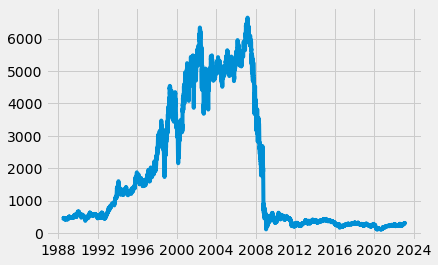

In [258]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['Close'])

In [259]:
import numpy as np

# define the function with the input arguments
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n):
    """
    Retreives the three previous stock values and then what it was on that day from the input date.
    """
    # convert the input string dates to datetime objects
    first_date = str_to_datetime(first_date_str)
    last_date = str_to_datetime(last_date_str)

    # set the target date to the first date
    target_date = first_date

    # initialize empty lists to store the dates and data for each window
    dates = []
    X, Y = [], []

    # set a flag to check if we have reached the last date
    last_time = False

    # loop until we reach the last date
    while True:
        # select the subset of the dataframe up to the target date and tail the last n+1 rows
        df_subset = dataframe.loc[:target_date].tail(n+1)

        # if the subset is not of size n+1, print an error message and return None
        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return None

        # extract the values for X (the independent variables) and Y (the dependent variable)
        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        # append the target date, X values, and Y value to the lists
        dates.append(target_date)
        X.append(x)
        Y.append(y)

        # select the next week of data and extract the next date from the dataframe
        next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        # check if we have reached the last date
        if last_time:
            break

        # update the target date
        target_date = next_date

        # check if we have reached the last date
        if target_date == last_date:
            last_time = True

    # create a new dataframe to store the results
    ret_df = pd.DataFrame({})

    # add the dates to the dataframe
    ret_df['Target Date'] = dates

    # convert the lists of X and Y values to numpy arrays
    X = np.array(X)

    # loop over the columns of X and add them to the dataframe as separate columns
    for i in range(0, n):
        ret_df[f'Target-{n-i}'] = X[:, i]

    # add the Y values to the dataframe
    ret_df['Target'] = Y

    # return the dataframe
    return ret_df


n = 60
# Start day second time around: '2021-03-25'
windowed_df = df_to_windowed_df(df, 
                                '1988-10-07', # Make sure date is in range available on Yahoo Finance
                                '2023-02-17', 
                                n=n)
windowed_df

,Target Date,Target-60,Target-59,Target-58,Target-57,Target-56,Target-55,Target-54,Target-53,Target-52,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,1988-10-07,453.543701,453.543701,458.473602,468.333191,468.333191,465.868286,465.868286,464.635803,456.008606,...,423.964813,423.964813,425.197205,430.127106,435.056885,430.127106,430.127106,428.894592,428.894592,428.894592
1,1988-10-10,453.543701,458.473602,468.333191,468.333191,465.868286,465.868286,464.635803,456.008606,453.543701,...,423.964813,425.197205,430.127106,435.056885,430.127106,430.127106,428.894592,428.894592,428.894592,435.056885
2,1988-10-11,458.473602,468.333191,468.333191,465.868286,465.868286,464.635803,456.008606,453.543701,456.008606,...,425.197205,430.127106,435.056885,430.127106,430.127106,428.894592,428.894592,428.894592,435.056885,436.289398
3,1988-10-12,468.333191,468.333191,465.868286,465.868286,464.635803,456.008606,453.543701,456.008606,454.776215,...,430.127106,435.056885,430.127106,430.127106,428.894592,428.894592,428.894592,435.056885,436.289398,433.824402
4,1988-10-13,468.333191,465.868286,465.868286,464.635803,456.008606,453.543701,456.008606,454.776215,449.846405,...,435.056885,430.127106,430.127106,428.894592,428.894592,428.894592,435.056885,436.289398,433.824402,433.824402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8820,2023-02-13,246.899994,253.000000,258.100006,255.600006,254.600006,254.300003,258.700012,256.000000,254.600006,...,308.000000,308.399994,309.899994,306.200012,300.200012,304.000000,305.299988,306.399994,304.500000,303.799988
8821,2023-02-14,253.000000,258.100006,255.600006,254.600006,254.300003,258.700012,256.000000,254.600006,260.500000,...,308.399994,309.899994,306.200012,300.200012,304.000000,305.299988,306.399994,304.500000,303.799988,305.000000
8822,2023-02-15,258.100006,255.600006,254.600006,254.300003,258.700012,256.000000,254.600006,260.500000,261.899994,...,309.899994,306.200012,300.200012,304.000000,305.299988,306.399994,304.500000,303.799988,305.000000,300.799988
8823,2023-02-16,255.600006,254.600006,254.300003,258.700012,256.000000,254.600006,260.500000,261.899994,257.399994,...,306.200012,300.200012,304.000000,305.299988,306.399994,304.500000,303.799988,305.000000,300.799988,305.600006


In [260]:
def windowed_df_to_date_X_y(windowed_dataframe):
    df_as_np = windowed_dataframe.to_numpy()
    dates = df_as_np[:, 0]
    middle_matrix = df_as_np[:, 1:-1] # Target-1,2,3 
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1)) # 1 for one variable (at a time) - univariate forcasting

    Y = df_as_np[:, -1] # Only want last column

    return dates, X.astype(np.float32), Y.astype(np.float32) # 

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((8825,), (8825, 60, 1), (8825,))

Text(0.5, 1.0, 'Training, Validation, and Test Data Visulised')

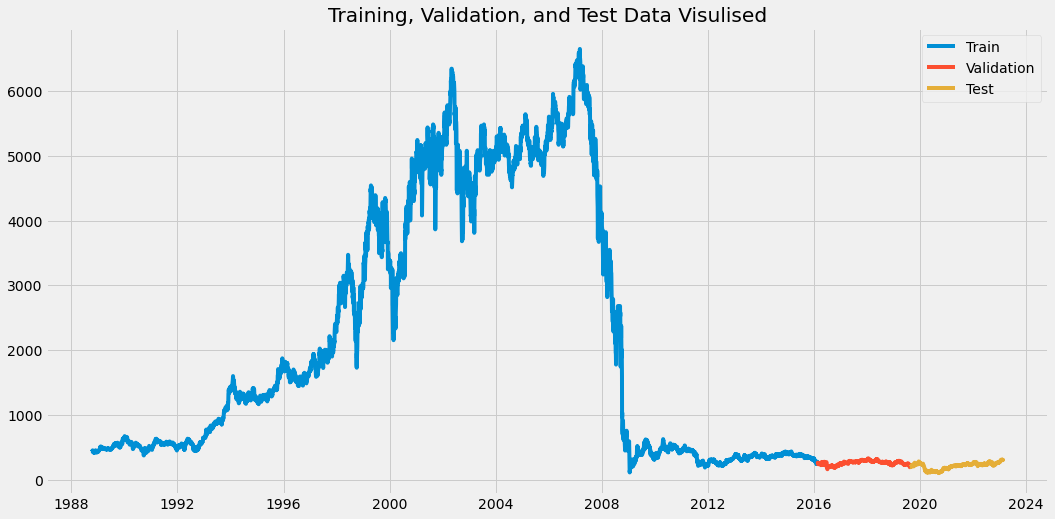

In [261]:
q_80 = int(len(dates) * 0.8)
q_90 = int(len(dates) * 0.9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80] # Train on first 80% of data
dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90] # Val on 10% of previously unseen data 80-90%
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:] # Train on 10% of previously unseen data 90-100%

plt.figure(figsize=(16,8))
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test'])
plt.title('Training, Validation, and Test Data Visulised')

In [262]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((n, 1)) # (3 days in the past, 1 features - univariate forcasting)
                    ,layers.LSTM(64)
                    ,layers.Dense(32, activation='relu')
                    ,layers.Dense(32, activation='relu')
                    ,layers.Dense(1) # Only want to predict the next 1 value
                    ]) 

model.compile(loss='mse'
            ,optimizer=Adam(learning_rate=0.001)
            ,metrics=['mean_absolute_error']
            )

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)


Epoch 1/10


2023-02-18 20:48:01.635105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 20:48:01.930257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 20:48:03.202474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


221/221 [==============================] - ETA: 0s - loss: 8348290.5000 - mean_absolute_error: 2085.3794

2023-02-18 20:48:10.694513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 20:48:10.804995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


221/221 [==============================] - 11s 36ms/step - loss: 8348290.5000 - mean_absolute_error: 2085.3794 - val_loss: 176038.1875 - val_mean_absolute_error: 418.4984
Epoch 2/10
221/221 [==============================] - 7s 30ms/step - loss: 3834789.7500 - mean_absolute_error: 1424.8197 - val_loss: 449969.4062 - val_mean_absolute_error: 670.7201
Epoch 3/10
221/221 [==============================] - 6s 29ms/step - loss: 657227.8125 - mean_absolute_error: 485.0115 - val_loss: 142.4304 - val_mean_absolute_error: 10.1835
Epoch 4/10
221/221 [==============================] - 7s 30ms/step - loss: 94887.6250 - mean_absolute_error: 166.9291 - val_loss: 1882.1055 - val_mean_absolute_error: 40.2567
Epoch 5/10
221/221 [==============================] - 7s 32ms/step - loss: 49582.0703 - mean_absolute_error: 112.8178 - val_loss: 55.6932 - val_mean_absolute_error: 5.1387
Epoch 6/10
221/221 [==============================] - 7s 30ms/step - loss: 75185.9531 - mean_absolute_error: 139.5242 - val_lo

2023-02-18 20:49:20.273974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-18 20:49:20.367449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


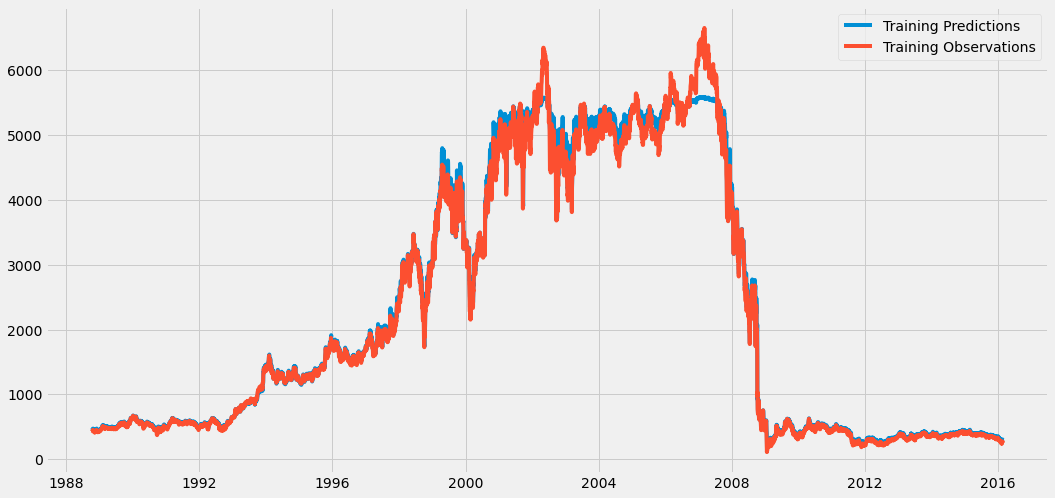

In [263]:
train_predictions = model.predict(X_train).flatten()

plt.figure(figsize=(16,8))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

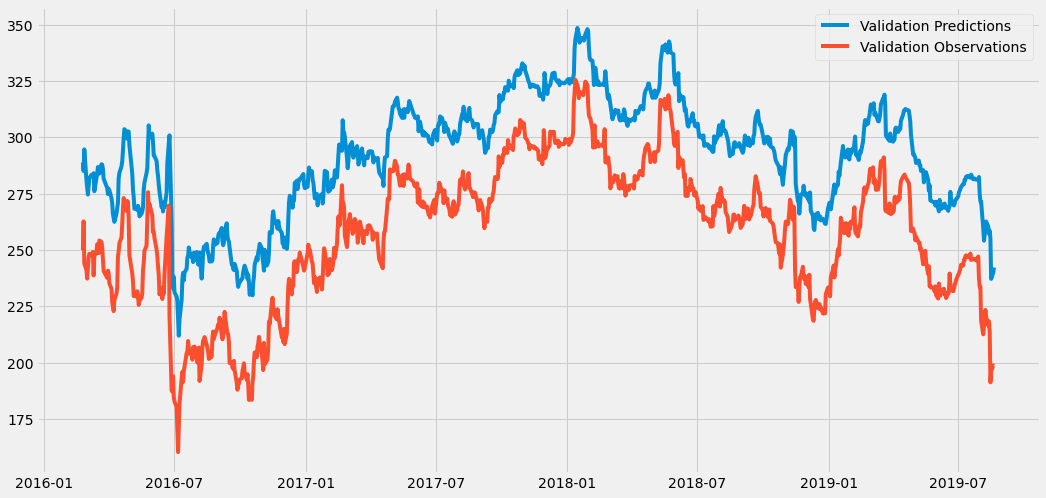

In [264]:
val_predictions = model.predict(X_val).flatten()

plt.figure(figsize=(16,8))
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

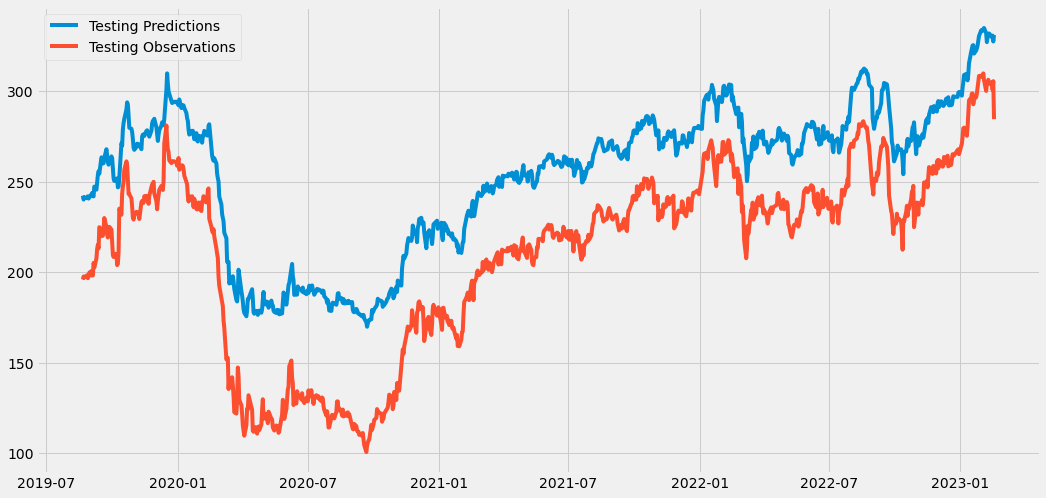

In [265]:
test_predictions = model.predict(X_test).flatten()

plt.figure(figsize=(16,8))
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

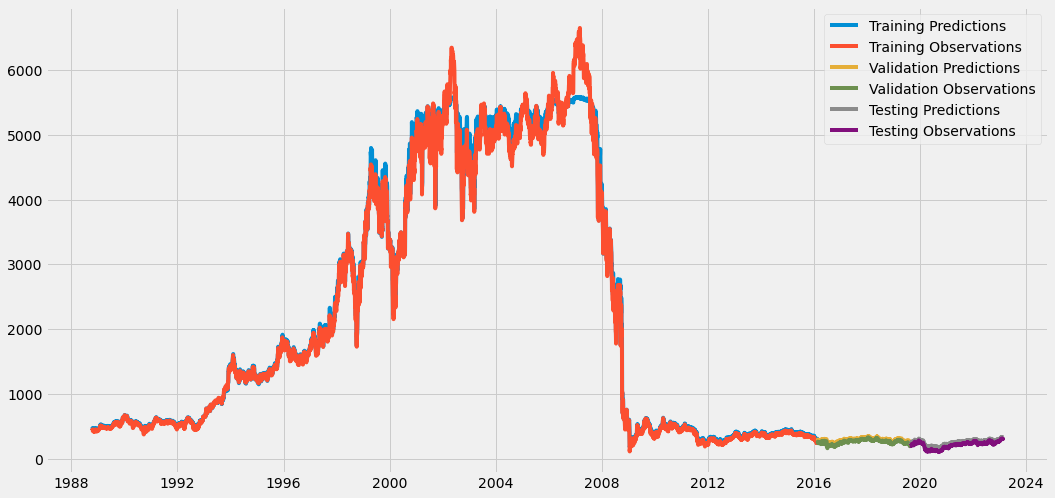

In [266]:
plt.figure(figsize=(16,8))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [267]:
# Use data after 2016 to train - much better 

In [269]:
# Predict long term price

from copy import deepcopy 
# A deep copy constructs a new compound object and then, recursively, inserts copies into it of the objects found in the original.

recursive_predictions = []
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
  last_window = deepcopy(X_train[-1])
  next_prediction = model.predict(np.array([last_window])).flatten()
  recursive_predictions.append(next_prediction)
  last_window[-1] = next_prediction

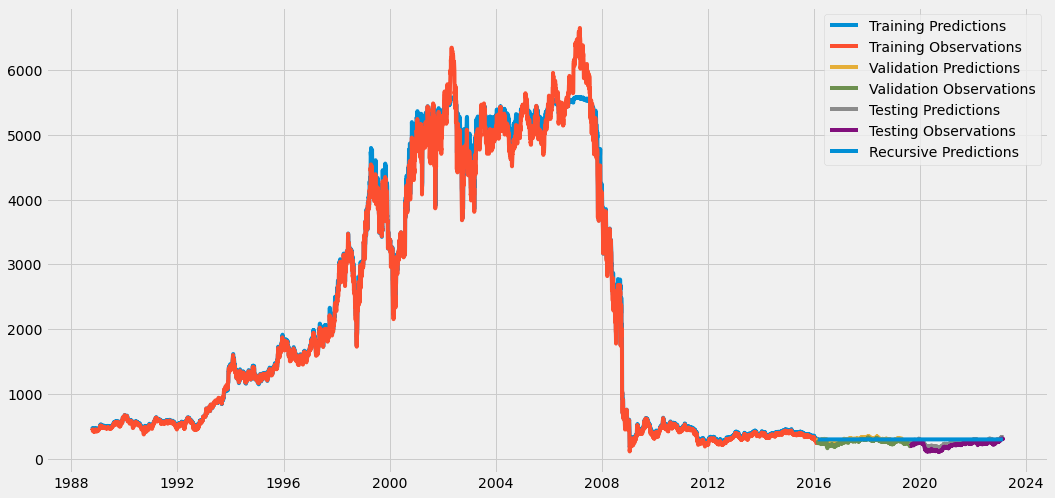

In [270]:
plt.figure(figsize=(16,8))
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.plot(recursive_dates, recursive_predictions)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions'])